### Load the library

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from prettytable import PrettyTable

### Load data

In [3]:
df = pd.read_csv("../data/laptop_final.csv")
df

,link,name,Display Size,Resolution: width,Resolution: height,Refresh Rate,Panel Type,Disk Capacity,SSD,HDD,...,GPU: Name,GPU: Process Size (nm),GPU: Architecture,GPU: Memory Type,GPU: Memory Frequency (MHz),GPU: Memory Size,GPU: Base Clock,GPU: Memory Bus,GPU: Release quarter,GPU: Power Consumption
0,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Strix G17,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0
1,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,16000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Zephyrus Duo 16,16.0,2560.0,1600.0,240.0,IPS + FreeSync,2000.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://laptopmedia.com/laptop-specs/asus-rog-...,ASUS ROG Strix G17,17.3,2560.0,1440.0,240.0,IPS + G-Sync,2000.0,1.0,0.0,...,"geforce rtx 4060 (laptop, 140w)",4.0,Ada Lovelace,DDR6,2000.0,8.0,1920.0,128.0,2023.0,140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289166,https://laptopmedia.com/laptop-specs/acer-aspi...,Acer Aspire 5,17.3,1920.0,1080.0,60.0,IPS,256.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289167,https://laptopmedia.com/laptop-specs/hp-17-5749/,HP 17,17.3,1600.0,900.0,60.0,TN,256.0,1.0,0.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0
289168,https://laptopmedia.com/laptop-specs/hp-17-17-...,HP 17 (17-by4000),17.3,1600.0,900.0,60.0,TN,2256.0,1.0,1.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0
289169,https://laptopmedia.com/laptop-specs/hp-17-4594/,HP 17,17.3,1600.0,900.0,60.0,TN,1512.0,1.0,1.0,...,iris xe graphics g4,10.0,Tiger Lake GT2,shared,0.0,0.0,300.0,0.0,2020.5,15.0


In [4]:
# Drop unecessary columns
# Drop Ethernet LAN due to its large missing values 
df2=df.drop(columns=["link","name","Total Score","Display Score","Portability Score","Play Score","Cost","CPU: Codename","GPU: Name","CPU: Name","Ethernet LAN"])
df2 = df2.drop_duplicates()

#### Drop nan values

In [5]:
df2.isna().sum()

Display Size                                   0
Resolution: width                              0
Resolution: height                             0
Refresh Rate                                   0
Panel Type                                     0
Disk Capacity                                  0
SSD                                            0
HDD                                            0
SSHD                                           0
Optane                                         0
RAM Capacity                                 263
RAM Type                                   27120
OS                                           665
Body material: plastic / polycarbonate         0
Body material: aluminum                        0
Body material: magnesium alloy                 0
Body material: glass fiber                     0
Body material: carbon                          0
Body material: magnesium-lithium alloy         0
Body material: plastic                         0
Body material: matte

In [56]:
df3 = df2.dropna() # drop all nan value due to the large datset 
print("The number of data points before drop nan is:{} and after drop nan values is:{}".format(df.shape[0], df2.shape[0]))

The number of data points before drop nan is:289171 and after drop nan values is:157767


### Add more features following our knowledge about laptop architecture


+ **CPU Processing Power** (Ghz)= CPU: Core x CPU: Base Frequency
   
      - CPU: Core is the number of core in CPU 
      - CPU: Base Frequency is the speed where each core operates (GHz)
  
  ⇒ This feature tells the total number of cycles the CPU can operate in a second (Ghz)

+ **GPU Band Width** (bits/s) = GPU: Memory Frequency × GPU: Memory Bus 
  
      - GPU: Memory Frequency is the clock speed of GPU memory (Mhz)
      - GPU: Memory Bus is the number of bits the memory can transfer per clock cycle (bits/cycle)
  
  ⇒ Represent how fast data can move between the GPU memory and the GPU’s cores for processing (bits/s)

+ **GPU Efficiency** (cycles/J) = GPU: Base Clock / GPU: Power Consumption

      -GPU: Base Clock is the clock speed of GPU core (Ghz)
      -GPU: Power Consumption is the power GPU uses during operation (W)

  ⇒ Represent how much work GPU can do per unit of energy consumption (cycles/J)

In [57]:
df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
df3["GPU: Efficiency"]=df3["GPU: Base Clock"]/df3["GPU: Power Consumption"]
added_features=["CPU: Processing Power","GPU: Band Width","GPU: Efficiency"]

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14760\2940952750.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["CPU: Processing Power"]=df3["CPU: Core"]*df3["CPU: Base frequency"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14760\2940952750.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["GPU: Band Width"]=df3["GPU: Memory Frequency (MHz)"]*df3["GPU: Memory Bus"]
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_14760\2940952750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

#### Train Test split 

In [58]:
target="Work Score"
X=df3.drop(columns=[target])
y=df3[target]

In [59]:
# train validation split with ratio is 0.2 
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=10)
# features for encoding 
cols_to_encode=["Panel Type","RAM Type","OS","GPU: Architecture","GPU: Memory Type"]

#### Encode categorical columns using target encoding

In [60]:
for col in cols_to_encode:
    print(f"Number of unique values in {col}: ",df3[col].nunique())

Number of unique values in Panel Type:  11
Number of unique values in RAM Type:  5
Number of unique values in OS:  9
Number of unique values in GPU: Architecture:  40
Number of unique values in GPU: Memory Type:  3


In [61]:
# Encode the categorical features 
encoder=TargetEncoder(cols=cols_to_encode)
X_train=encoder.fit_transform(X_train,y_train)
X_test=encoder.transform(X_test)

### Features Selection

In [62]:
# identify the numerical and the categorical features for features selection
numerical_features=["Display Size","Refresh Rate","Resolution: width","Resolution: height","Disk Capacity","RAM Capacity","Dimension: Depth","Weight",
                    "Num of M.2 Slot","USB Type-C","USB Type-A","HDMI","Bluetooth",
                    "CPU: Max operating temperature","CPU: Core","CPU: Thread","CPU: Base frequency",
                    "CPU: Max frequency","CPU: Release quarter","CPU: LL Cache","CPU: Lithography",
                    "GPU: Process Size (nm)","GPU: Memory Frequency (MHz)","GPU: Memory Size",
                    "GPU: Base Clock","GPU: Memory Bus","GPU: Release quarter","GPU: Power Consumption"]+added_features          
categorical_features=list(set(df3.columns.tolist())-set(numerical_features+[target]))
print(categorical_features)
print(len(categorical_features))

['Body material: carbon', 'Body material: black synthetic material', 'Body material: plastic', 'SSHD', 'HDD', 'Optane', 'GPU: Architecture', 'Body material: magnesium alloy', 'RAM Type', 'GPU: Memory Type', 'Body material: aluminum', 'Body material: glass fiber', 'Body material: matte', 'Backlit keyboard', 'Body material: magnesium-lithium alloy', 'Body material: plastic / polycarbonate', 'Security Lock slot', 'OS', 'Fingerprint reader', 'SSD', 'Panel Type', 'Card Reader']
22


Using mutual info and anova to find the most relevant categorical features

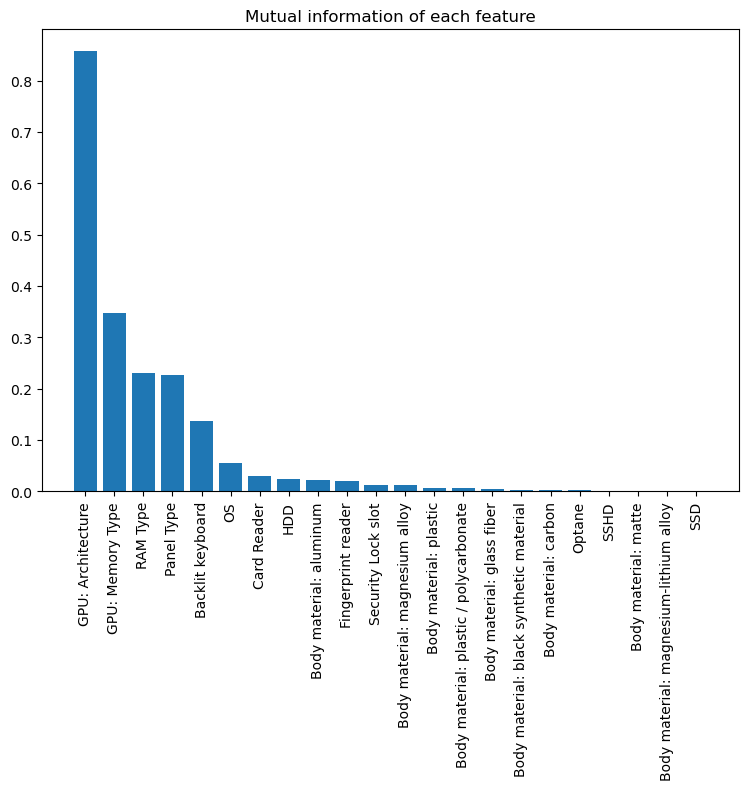

In [63]:
# mutual info
fs = SelectKBest(score_func=mutual_info_regression, k=10)
fs.fit(X_train[categorical_features],y_train)
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
d={a:b for a,b in d}
plt.figure(figsize=(9,6))
plt.bar(d.keys(),d.values())
plt.xticks(rotation=90)
plt.title("Mutual information of each feature")
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [ 1  2 12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


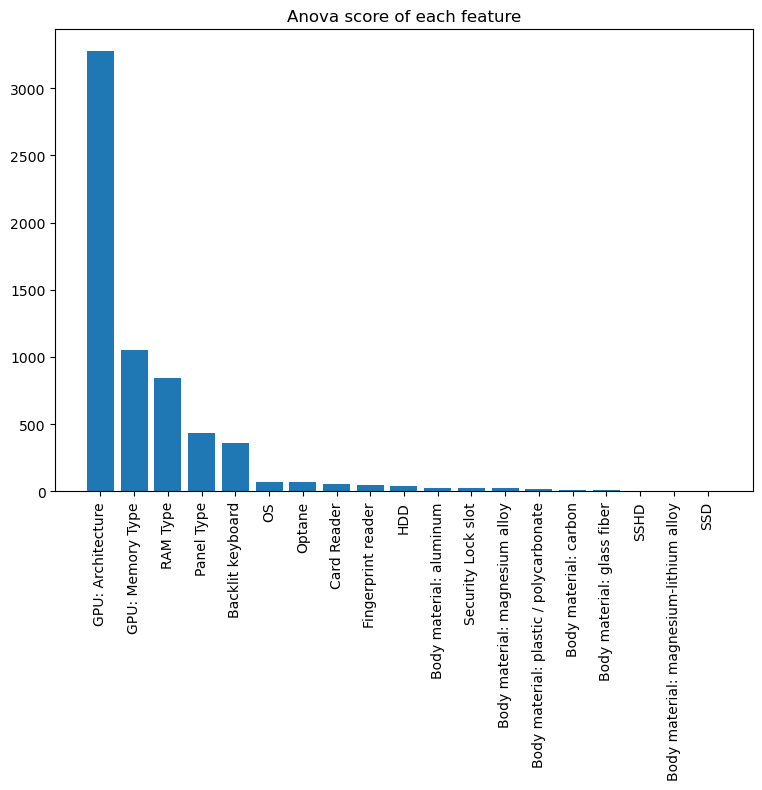

In [64]:
#anova
fs2 = SelectKBest(score_func=f_classif, k=10)
fs2.fit(X_train[categorical_features],y_train)
fs2.get_feature_names_out()
e=sorted([(a,b) for a,b in zip(categorical_features,fs2.scores_) if not np.isnan(b)],key=lambda x:x[1],reverse=True)
e={a:b for a,b in e}
plt.figure(figsize=(9,6))
plt.bar(e.keys(),e.values())
plt.xticks(rotation=90) 
plt.title("Anova score of each feature")
plt.show()

Using pearson correlation, spearman to find the most relevant in numerical features

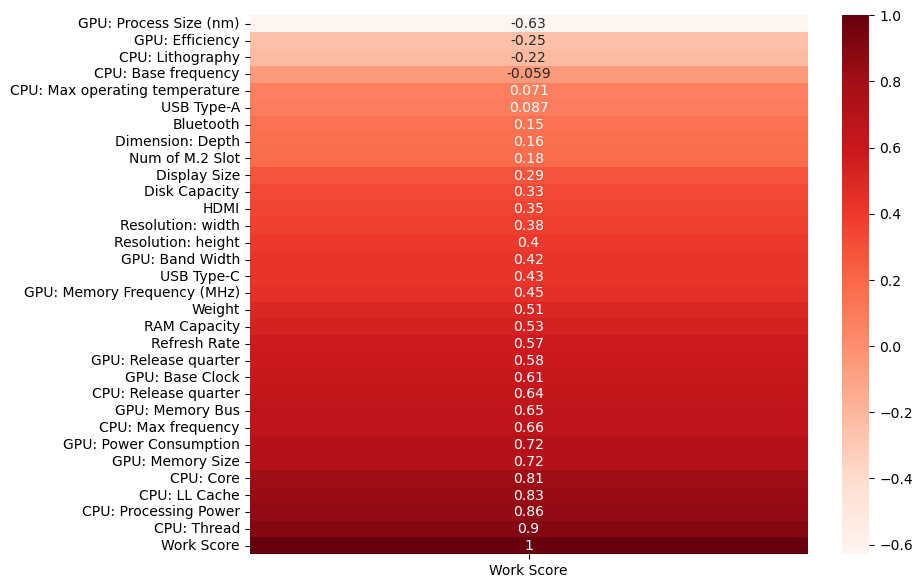

In [65]:
# using pearsonscore
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr()[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

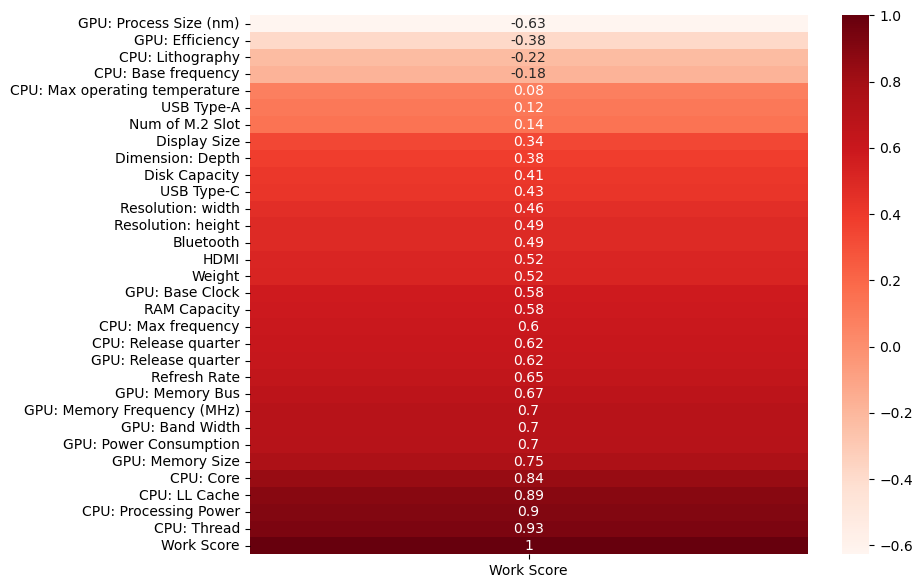

In [66]:
# using spearman score
train_set=X_train.join(y_train)
corr_df=train_set[numerical_features+[target]]
target_correlation = corr_df.corr(method = 'spearman')[[target]]
plt.figure(figsize=(9,7))
sns.heatmap(target_correlation.sort_values(by=target), annot=True, cmap=plt.cm.Reds)
plt.show()

Using Permutation Importance method to choose important features in 2 groups

In [67]:
# Choose candidate features in 2 groups
candidate_num_features = [f for f in target_correlation.index if abs(target_correlation[target].loc[f])>=0.5 and f!=target]
d=sorted([(a,b) for a,b in zip(categorical_features,fs.scores_)],key=lambda x:x[1],reverse=True)
candidate_cat_features = list(feat[0] for feat in d[:5])
candidate_featues = candidate_cat_features + candidate_num_features
print(candidate_featues)

['GPU: Architecture', 'GPU: Memory Type', 'RAM Type', 'Panel Type', 'Backlit keyboard', 'Refresh Rate', 'RAM Capacity', 'Weight', 'HDMI', 'CPU: Core', 'CPU: Thread', 'CPU: Max frequency', 'CPU: Release quarter', 'CPU: LL Cache', 'GPU: Process Size (nm)', 'GPU: Memory Frequency (MHz)', 'GPU: Memory Size', 'GPU: Base Clock', 'GPU: Memory Bus', 'GPU: Release quarter', 'GPU: Power Consumption', 'CPU: Processing Power', 'GPU: Band Width']


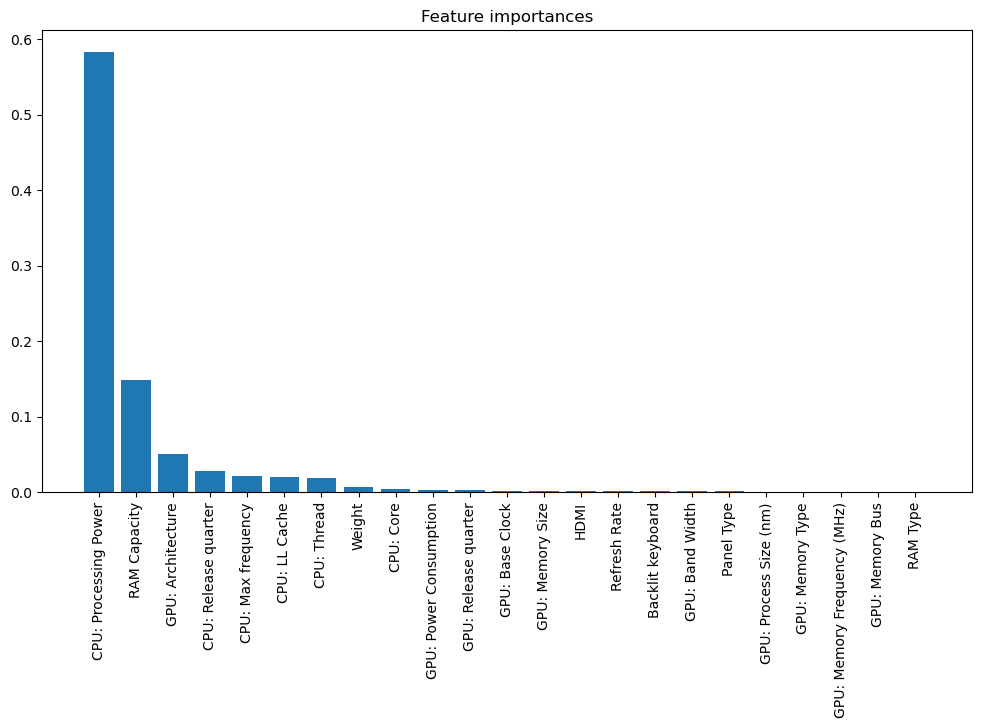

In [68]:
candidate_X = X_train[candidate_featues]
model_to_select_feature = RandomForestRegressor(n_estimators=5,min_samples_leaf=2)
model_to_select_feature.fit(candidate_X, y_train)
imp_dict = permutation_importance(model_to_select_feature,candidate_X,y_train,n_repeats=10,random_state=42,scoring="r2",n_jobs=-1)
imp_score=imp_dict.importances_mean
indices = np.argsort(imp_score)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature importances')
plt.bar(range(len(indices)), imp_score[indices])
plt.xticks(range(len(indices)), candidate_X.columns[indices], rotation='vertical')
plt.show()

In [69]:
#Choose importatn features based on the importance score in RF
chosen_features = [c for c in candidate_X.columns[indices[:10]]]
chosen_features

['CPU: Processing Power',
 'RAM Capacity',
 'GPU: Architecture',
 'CPU: Release quarter',
 'CPU: Max frequency',
 'CPU: LL Cache',
 'CPU: Thread',
 'Weight',
 'CPU: Core',
 'GPU: Power Consumption']

#### Keep the selected feature only on dataset

In [70]:
better_X_train=X_train[chosen_features]
better_X_test=X_test[chosen_features]

#### Normalize data

In [73]:
chosen_num_features=[f for f in chosen_features if f in numerical_features]

In [74]:
scaler = StandardScaler()
best_X_train=better_X_train.copy()
best_X_test=better_X_test.copy()
best_X_train[chosen_num_features]=scaler.fit_transform(better_X_train[chosen_num_features])
best_X_test[chosen_num_features] = scaler.transform(better_X_test[chosen_num_features])

### Fine-tune parameters

In [75]:
models={
    model_name:{} for model_name in ["Gradient Boosting",'KNN','Random Forest']
} 
def best_params_finder(model, param_grid, cv=3, scoring='r2', X_train=best_X_train, y_train=y_train, X_test=best_X_test, y_test=y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=-1,return_train_score=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    results_df = pd.DataFrame(grid_search.cv_results_)
    #print("\nDetailed Grid Search Results:")
    #print(results_df[['params','mean_train_score', 'std_train_score','mean_test_score', 'std_test_score','rank_test_score']])
    print(f"\nBest Parameters: {best_params}")
    print(f"Test Score with Best Estimator: {test_score}")
    return best_params

Gradient Boosting Regression

In [76]:
gbr=GradientBoostingRegressor()
params={"n_estimators":[100,200,500],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [77]:
best_params=best_params_finder(gbr,params)
gbr.set_params(**best_params)
models["Gradient Boosting"]["model"]=gbr


Best Parameters: {'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
Test Score with Best Estimator: 0.9845221109566065


KNN Regression

In [78]:
knn=KNeighborsRegressor()
params={"n_neighbors":[5,10,15,20]}

In [79]:
best_params=best_params_finder(knn,params)
knn.set_params(**best_params)
models["KNN"]["model"]=knn


Best Parameters: {'n_neighbors': 10}
Test Score with Best Estimator: 0.9824011757084786


Random Forest Regression 

In [80]:
rf=RandomForestRegressor()
params={"n_estimators":[10,25,50],"min_samples_leaf":[2,5],"min_samples_split":[2,5,10]}

In [81]:
best_params=best_params_finder(rf,params)
rf.set_params(**best_params)
models["Random Forest"]["model"]=rf


Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Test Score with Best Estimator: 0.9852675014457425


#### Results of each model in this dataset after fine-tuned hyper-parameters

In [82]:
def train(X_train=best_X_train, y_train=y_train, X_test=best_X_test, y_test=y_test):
    for name in models:
        print(f"Training and evaluating {name}...")
        model=models[name]["model"]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_absolute_percentage_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        models[name]["result"]=[mse,r2]
def display_result():
    table = PrettyTable()
    table.field_names = ["Model","MAPE","R2 Score"]
    for name in models:
        table.add_row([name,  f"{models[name]["result"][0]:.4f}", f"{models[name]["result"][1]:.4f}"])
    print(table)

In [83]:
train()

Training and evaluating Gradient Boosting...
Training and evaluating KNN...
Training and evaluating Random Forest...


In [84]:
display_result()

+-------------------+--------+----------+
|       Model       |  MAPE  | R2 Score |
+-------------------+--------+----------+
| Gradient Boosting | 0.0189 |  0.9845  |
|        KNN        | 0.0182 |  0.9824  |
|   Random Forest   | 0.0169 |  0.9853  |
+-------------------+--------+----------+


### Inference

In [85]:
data_to_inference=best_X_test.join(df["link"]) 
data_to_inference

,CPU: Processing Power,RAM Capacity,GPU: Architecture,CPU: Release quarter,CPU: Max frequency,CPU: LL Cache,CPU: Thread,Weight,CPU: Core,GPU: Power Consumption,link
132607,-0.739128,-1.022085,5.612725,-0.311797,-0.626158,-0.885000,-0.831070,-0.818987,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/dell-vost...
22694,1.603863,0.255092,8.189956,1.771270,1.058711,1.248991,1.343276,-0.094750,1.454614,1.189684,https://laptopmedia.com/laptop-specs/lenovo-le...
204440,-0.658335,-1.022085,5.612725,-0.832563,0.216277,-0.351502,-0.831070,-0.798869,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/acer-aspi...
227370,-0.213975,0.255092,6.122677,-1.092947,1.058711,-0.351502,-0.106288,2.520551,-0.377424,0.454523,https://laptopmedia.com/laptop-specs/hp-omen-g...
73343,0.270782,-1.022085,5.612725,0.729737,-0.626158,-0.351502,0.618494,-1.321929,0.996605,-0.910774,https://laptopmedia.com/laptop-specs/asus-zenb...
...,...,...,...,...,...,...,...,...,...,...,...
141385,-1.062299,0.680818,5.490275,0.729737,-0.626158,-0.618251,-0.831070,-0.839105,-0.377424,-0.280637,https://laptopmedia.com/laptop-specs/lenovo-id...
189089,-0.819921,-0.596359,5.612725,-0.832563,-1.187780,-0.885000,-0.831070,-0.718398,-0.835433,-0.910774,https://laptopmedia.com/laptop-specs/hp-eliteb...
30775,0.634350,-0.596359,8.189956,1.771270,0.777899,1.248991,0.618494,-0.094750,0.538595,1.294706,https://laptopmedia.com/laptop-specs/asus-rog-...
251762,1.462476,-0.596359,7.375437,0.729737,0.216277,1.248991,1.343276,1.112312,1.454614,1.714798,https://laptopmedia.com/laptop-specs/asus-tuf-...


In [86]:
def predict(model_name,laptop_link,X_test=best_X_test,y_test=y_test):
    index=data_to_inference[data_to_inference["link"]==laptop_link].index[0]
    y_pred=models[model_name]["model"].predict(X_test.loc[index].values.reshape(1,-1))
    #y_pred =  y_scaler.inverse_transform(scaled_y_pred.reshape(-1, 1))[0][0]
    y_true=y_test.loc[index]
    print(f"Predicted {target}: ",f"{y_pred[0]:.4f}")
    print(f"True {target}: ",y_true)

In [89]:
predict("KNN",data_to_inference.loc[68555].link)

Predicted Work Score:  7.0000
True Work Score:  6.8


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(
